While headlines focus on emerging health threats, a familiar enemy quietly claims more lives: heart disease remains America’s top killer, surpassing all forms of cancer combined. Heart disease, also known as cardiovascular disease, is a major public health issue affecting the heart and blood vessels. Poor heart health may be due to underlying risks including high blood pressure, high cholesterol, smoking, obesity, alcohol consumption, genetic predispositions and more. Due to these risks, conditions such as Coronary Artery Disease, heart failure, heart arrhythmias, heart valve disease, and pericardial disease are bound to happen. 

In [36]:

# Importing necessary libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils import resample

data = pd.read_csv('framingham.csv')
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


Our response variable will be the difference between systolic blood pressure and diastolic blood pressure. This difference is also known as pulse pressure and is a good indicator of heart health. The model is meant to predict the pulse pressure (sysBP-diaBP) based on certain explanatory variables.

In [37]:
data["sys_dia_diff"] = data["sysBP"] - data["diaBP"]
data.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sys_dia_diff
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0,36.0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0,40.0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0,47.5
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1,55.0
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0,46.0


In [38]:
print(data.shape[0])
data.isnull().sum()

4240


male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
sys_dia_diff         0
dtype: int64

Handling missing/null values in the data. We will handle the missing values using imputation

In [39]:
mean_imputer = SimpleImputer(strategy='mean')
mean_cols = ['heartRate']
data[mean_cols] = mean_imputer.fit_transform(data[mean_cols])

median_imputer = SimpleImputer(strategy='median')
median_cols = ['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'glucose']
data[median_cols] = median_imputer.fit_transform(data[median_cols])

# # Handling outliers using the IQR method
# def handle_outliers_with_IQR(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR
#     df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
# continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
# for col in continuous_cols:
#     handle_outliers_with_IQR(data, col)

# # Checking if the data is imbalanced
# target_column = "sys_dia_diff"
# class_counts = data[target_column].value_counts()
# plt.figure(figsize=(8, 5))
# sns.barplot(x=class_counts.index, y=class_counts.values)
# plt.title('Class Distribution of the Target Variable (TenYearCHD)')
# plt.xlabel('Class')
# plt.ylabel('Count')
# plt.show()

In [40]:
print(data.shape[0])
data.isnull().sum()

4240


male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
sys_dia_diff       0
dtype: int64

I want to check the colinearity between the explanatory variables to see which variables are useful and which ones I should drop.

In [41]:
#Graph the correlation between the explanatory variables 
corr_matrix = data.corr()
print(corr_matrix)

                     male       age  education  currentSmoker  cigsPerDay  \
male             1.000000 -0.029014   0.017265       0.197026    0.314849   
age             -0.029014  1.000000  -0.164016      -0.213662   -0.192017   
education        0.017265 -0.164016   1.000000       0.018270    0.007856   
currentSmoker    0.197026 -0.213662   0.018270       1.000000    0.760326   
cigsPerDay       0.314849 -0.192017   0.007856       0.760326    1.000000   
BPMeds          -0.051544  0.121011  -0.010445      -0.048348   -0.044697   
prevalentStroke -0.004550  0.057679  -0.035178      -0.032980   -0.032248   
prevalentHyp     0.005853  0.306799  -0.080780      -0.103710   -0.065541   
diabetes         0.015693  0.101314  -0.038204      -0.044285   -0.036173   
totChol         -0.069643  0.260527  -0.022851      -0.046391   -0.027134   
sysBP           -0.035879  0.394053  -0.128139      -0.130281   -0.088393   
diaBP            0.058199  0.205586  -0.061326      -0.107933   -0.056768   

In [42]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = data.assign(constant=1)  # Add constant column for intercept calculation
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            feature         VIF
0              male    1.199102
1               age    1.402939
2         education    1.054886
3     currentSmoker    2.454663
4        cigsPerDay    2.583027
5            BPMeds    1.101667
6   prevalentStroke    1.021078
7      prevalentHyp    2.054302
8          diabetes    1.589796
9           totChol    1.107283
10            sysBP         inf
11            diaBP         inf
12              BMI    1.235549
13        heartRate    1.095885
14          glucose    1.617161
15       TenYearCHD    1.107756
16     sys_dia_diff         inf
17         constant  201.394472


c:\Python311\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [43]:
#create new dataFram where sysBP and diaBP are dropped
farmingham = data.drop(columns=['sysBP', 'diaBP'])

#calculate the corr matrix and VIF values once again,
corr_matrix = farmingham.corr()
print(corr_matrix)

                     male       age  education  currentSmoker  cigsPerDay  \
male             1.000000 -0.029014   0.017265       0.197026    0.314849   
age             -0.029014  1.000000  -0.164016      -0.213662   -0.192017   
education        0.017265 -0.164016   1.000000       0.018270    0.007856   
currentSmoker    0.197026 -0.213662   0.018270       1.000000    0.760326   
cigsPerDay       0.314849 -0.192017   0.007856       0.760326    1.000000   
BPMeds          -0.051544  0.121011  -0.010445      -0.048348   -0.044697   
prevalentStroke -0.004550  0.057679  -0.035178      -0.032980   -0.032248   
prevalentHyp     0.005853  0.306799  -0.080780      -0.103710   -0.065541   
diabetes         0.015693  0.101314  -0.038204      -0.044285   -0.036173   
totChol         -0.069643  0.260527  -0.022851      -0.046391   -0.027134   
BMI              0.081852  0.135470  -0.135744      -0.167368   -0.092647   
heartRate       -0.116913 -0.012839  -0.053675       0.062678    0.074271   

In [44]:
X = farmingham.assign(constant=1)  # Add constant column for intercept calculation
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

            feature         VIF
0              male    1.191608
1               age    1.402660
2         education    1.054467
3     currentSmoker    2.452693
4        cigsPerDay    2.582926
5            BPMeds    1.099912
6   prevalentStroke    1.021069
7      prevalentHyp    1.597801
8          diabetes    1.589415
9           totChol    1.103437
10              BMI    1.167907
11        heartRate    1.079367
12          glucose    1.616907
13       TenYearCHD    1.106467
14     sys_dia_diff    1.669869
15         constant  166.039479


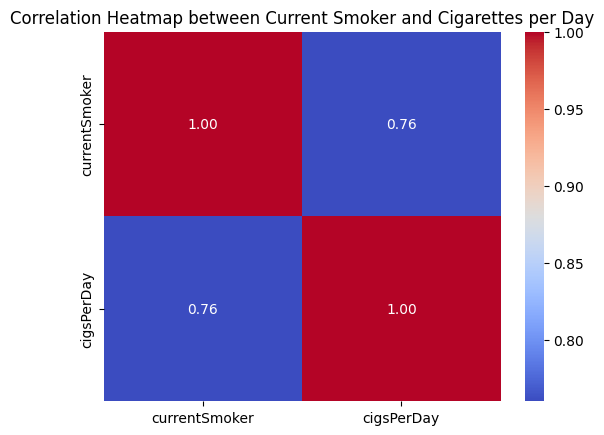

In [45]:
# Calculate the correlation matrix
correlation_matrix = farmingham[['currentSmoker', 'cigsPerDay']].corr()

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap between Current Smoker and Cigarettes per Day')
plt.show()

Now lets think about what explanatory variables I would like in my model. I'm thinking about using sequential feature selection to help me choose which variables to use.
["male", "age", "currentSmoker", "cigsPerDay", "BPMeds","prevalentHyp", "diabetes", "totChol", "BMI", "heartRate"]

In [46]:
#Define features and target
X = farmingham[["age", "cigsPerDay", "totChol", "BMI", "heartRate", 
                "glucose", "TenYearCHD","male", "currentSmoker", "BPMeds", 
                "prevalentHyp", "diabetes", "prevalentStroke"]]
y = farmingham["sys_dia_diff"]

#Separate continuous and categorical features
continuous_features = ["age", "cigsPerDay", "totChol", "BMI", "heartRate", "glucose", "TenYearCHD"]
categorical_features = ["male", "currentSmoker", "BPMeds", "prevalentHyp", "diabetes", "prevalentStroke"]

# Standardize continuous features
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X[continuous_features])

# Convert back to DataFrame
X_continuous_scaled = pd.DataFrame(X_continuous_scaled, columns=continuous_features)

# Combine with categorical features
X_combined = pd.concat([X_continuous_scaled, X[categorical_features].reset_index(drop=True)], axis=1)

In [47]:
# sklearn doesn't have adjusted R^2
def adjusted_r2_scorer(estimator, X, y):
    n = X_combined.shape[0]  # number of samples
    p = X_combined.shape[1]  # number of features
    r_squared = estimator.score(X, y)
    adj_r2 = 1 - ((1 - r_squared) * (n - 1) / (n - p - 1))
    return adj_r2

In [48]:


# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=27)

# Create a linear regression model
model = LinearRegression()

# Initialize Sequential Feature Selector with floating set to True
sfs = SFS(model,
          k_features='best',
          forward=True,
          floating=True,
          scoring=adjusted_r2_scorer,
          cv=5, #Cross validation: 5 different splits
          n_jobs=-1)

# Perform stepwise feature selection
sfs.fit(X_train, y_train)

# Get the selected features
selected_features = np.array(X_combined.columns)[list(sfs.k_feature_idx_)]
print('Stepwise Selection - Selected Features:', selected_features)

# Iterate through subsets and print information
for k in sorted(sfs.subsets_.keys(), reverse=False):
    feature_indices = list(sfs.subsets_[k]['feature_idx'])
    feature_names = [X_combined.columns[i] for i in feature_indices]
    avg_score = sfs.subsets_[k]['avg_score']  # Note: This score is using the entire dataset for each iteration
    print(f"Number of features: {k}, Features: {feature_names}, Score: {avg_score}")


# Subset the dataset with the selected features
X_train_selected = sfs.transform(X_train)
X_test_selected = sfs.transform(X_test)

Stepwise Selection - Selected Features: ['age' 'cigsPerDay' 'heartRate' 'glucose' 'TenYearCHD' 'male' 'BPMeds'
 'prevalentHyp' 'prevalentStroke']
Number of features: 1, Features: ['prevalentHyp'], Score: 0.2948443573729332
Number of features: 2, Features: ['age', 'prevalentHyp'], Score: 0.3714503933943979
Number of features: 3, Features: ['age', 'male', 'prevalentHyp'], Score: 0.3788041900777376
Number of features: 4, Features: ['age', 'glucose', 'male', 'prevalentHyp'], Score: 0.38479907885321685
Number of features: 5, Features: ['age', 'glucose', 'TenYearCHD', 'male', 'prevalentHyp'], Score: 0.38911232062984896
Number of features: 6, Features: ['age', 'glucose', 'TenYearCHD', 'male', 'BPMeds', 'prevalentHyp'], Score: 0.3927780879836404
Number of features: 7, Features: ['age', 'heartRate', 'glucose', 'TenYearCHD', 'male', 'BPMeds', 'prevalentHyp'], Score: 0.39473214837553083
Number of features: 8, Features: ['age', 'cigsPerDay', 'heartRate', 'glucose', 'TenYearCHD', 'male', 'BPMeds', 

In [49]:
# Fit the RandomForestRegressor model using the selected features on the training data
model.fit(X_train_selected, y_train)

# Predict on the test data using the model
y_pred = model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1)/(len(y_test)-X_test_selected.shape[1]-1)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)

Mean Squared Error: 133.3739895566813
R-squared: 0.3672138228730689
Adjusted R-squared: 0.36041778994449813


Here I will attempt to add in interactions between the explanatory variables in hopes that the adj r-squared can get lower and hopefully predict more accurately.

In [50]:
selected_interactions = [
    'age' 'cigsPerDay' 'totChol' 'BMI' 'heartRate' 'glucose' 'TenYearCHD'
    'male' 'currentSmoker' 'BPMeds' 'prevalentHyp' 'diabetes''prevalentStroke'
    'age cigsPerDay', 'age BMI', 'age glucose', 'age prevalentHyp',
    'cigsPerDay totChol', 'cigsPerDay BMI', 'cigsPerDay heartRate',
    'totChol BMI', 'totChol diabetes', 'BMI heartRate', 'BMI diabetes', 
    'BMI prevalentHyp', 'heartRate prevalentHyp', 'male age', 'male diabetes'
]
# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_combined)
poly_feature_names = poly.get_feature_names_out(X_combined.columns)

# Filter the features to keep only selected interactions
selected_indices = [i for i, feature in enumerate(poly_feature_names) if feature in selected_interactions or feature in X_combined.columns]
X_poly_selected = X_poly[:, selected_indices]
poly_feature_names_selected = np.array(poly_feature_names)[selected_indices]


In [51]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_selected, y, test_size=0.2, random_state=42)

# Create a Linear Regression model for faster initial feature selection
model = LinearRegression()

# Initialize Sequential Feature Selector with floating set to True
sfs = SFS(model,
          k_features='best',
          forward=True,
          floating=True,
          scoring=adjusted_r2_scorer,
          cv=5,
          n_jobs=-1)

# Perform stepwise feature selection
sfs.fit(X_train, y_train)

# Check if feature selection was successful
if hasattr(sfs, 'k_feature_idx_') and sfs.k_feature_idx_ is not None:
    # Get the selected features
    selected_feature_indices = list(sfs.k_feature_idx_)
    selected_features = np.array(poly_feature_names_selected)[selected_feature_indices]
    print('Stepwise Selection - Selected Features:', selected_features)

    # Iterate through subsets and print information
    for k in sorted(sfs.subsets_.keys(), reverse=False):
        feature_indices = list(sfs.subsets_[k]['feature_idx'])
        feature_names = [poly_feature_names_selected[i] for i in feature_indices]
        avg_score = sfs.subsets_[k]['avg_score']
        print(f"Number of features: {k}, Features: {feature_names}, Score: {avg_score}")

    # Subset the dataset with the selected features
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)

    # You can now proceed to fit a model using X_train_selected and evaluate it on X_test_selected
else:
    print("Feature selection failed or no features were selected.")

Stepwise Selection - Selected Features: ['age' 'cigsPerDay' 'totChol' 'glucose' 'TenYearCHD' 'male' 'BPMeds'
 'prevalentHyp' 'prevalentStroke' 'age prevalentHyp'
 'heartRate prevalentHyp']
Number of features: 1, Features: ['prevalentHyp'], Score: 0.305665904480784
Number of features: 2, Features: ['prevalentHyp', 'age prevalentHyp'], Score: 0.37949899995743397
Number of features: 3, Features: ['age', 'prevalentHyp', 'age prevalentHyp'], Score: 0.4001693610827143
Number of features: 4, Features: ['age', 'male', 'prevalentHyp', 'age prevalentHyp'], Score: 0.4071977825376294
Number of features: 5, Features: ['age', 'glucose', 'male', 'prevalentHyp', 'age prevalentHyp'], Score: 0.4125253864256315
Number of features: 6, Features: ['age', 'glucose', 'male', 'BPMeds', 'prevalentHyp', 'age prevalentHyp'], Score: 0.4159288103929951
Number of features: 7, Features: ['age', 'glucose', 'male', 'BPMeds', 'prevalentHyp', 'age prevalentHyp', 'heartRate prevalentHyp'], Score: 0.41887720372367276
Numbe

In [52]:
# Fit the RandomForestRegressor model using the selected features on the training data
model.fit(X_train_selected, y_train)

# Predict on the test data using the model
y_pred = model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1)/(len(y_test)-X_test_selected.shape[1]-1)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)

Mean Squared Error: 133.65777778062977
R-squared: 0.3521417492961607
Adjusted R-squared: 0.3436172986290049


Almost completely hopeless and on the verge of giving up on this dataset, I decided to look at the data points one more time and more thoroughly. I realized that in specific discrete columns there is a large deficit in class count. This can be a major reason my model isn't performing well -> Therefore I tried something called upsampling, where I upsampled the columns that had a large difference between the majority and minority class counts.

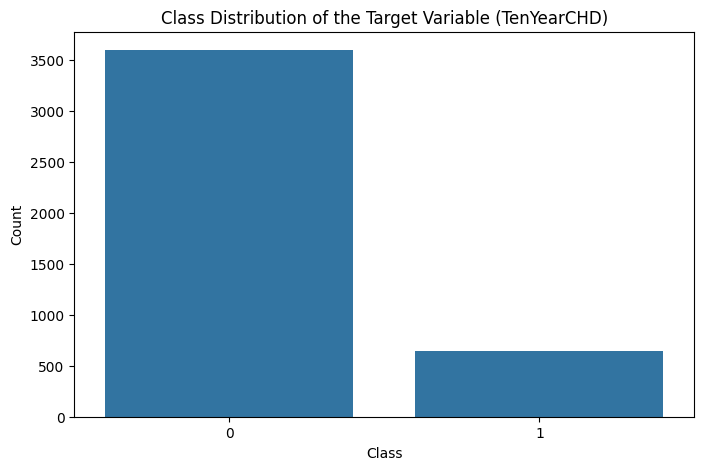

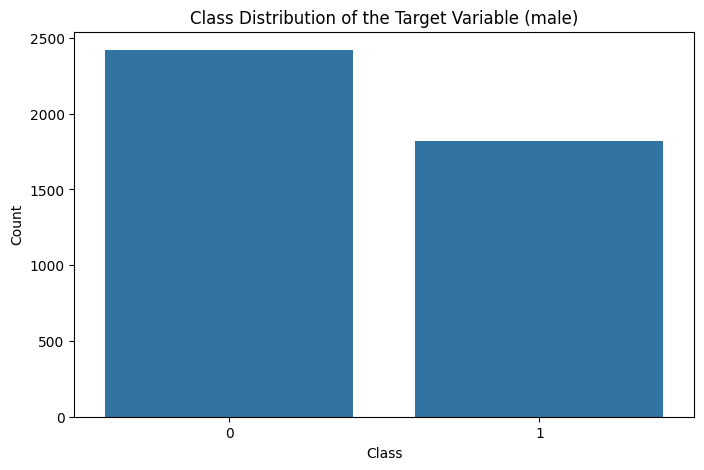

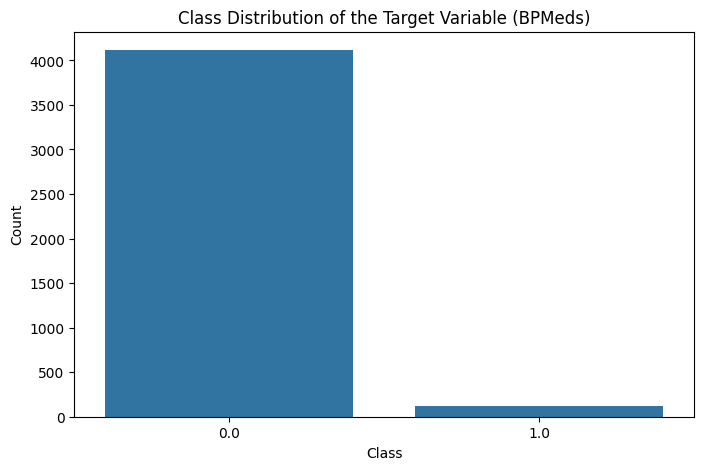

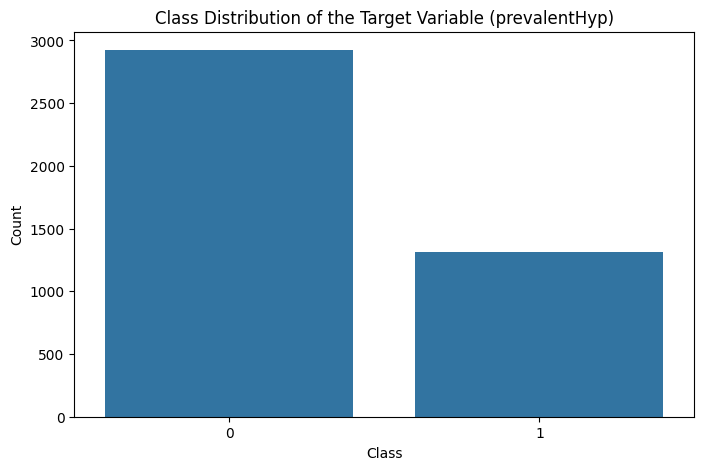

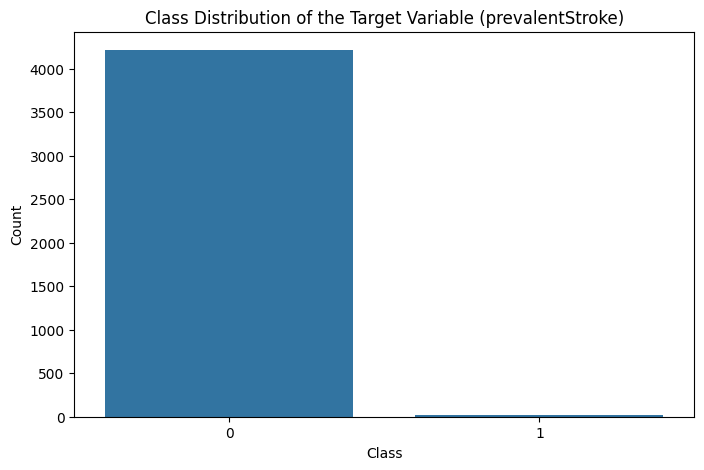

In [53]:
# Checking if the data is imbalanced
target_columns = ['TenYearCHD','male', 'BPMeds','prevalentHyp','prevalentStroke']

# Plot the class distribution for each target column
for target_column in target_columns:
    class_counts = data[target_column].value_counts()

    # Plotting the class distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=class_counts.index, y=class_counts.values)
    plt.title(f'Class Distribution of the Target Variable ({target_column})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

In [54]:
# Upsample each target column
for target_column in target_columns:
    # Upsampling the minority class
    data_majority = data[data[target_column] == 0]
    data_minority = data[data[target_column] == 1]
    data_minority_upsampled = resample(data_minority, replace=True, n_samples=len(data_majority), random_state=123)
    data_upsampled = pd.concat([data_majority, data_minority_upsampled])

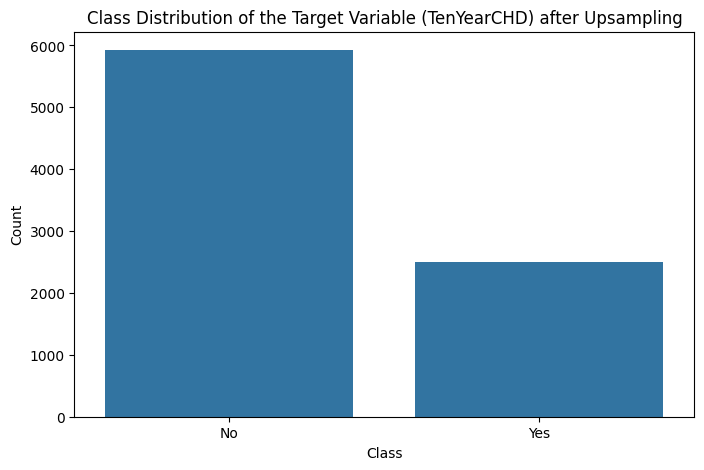

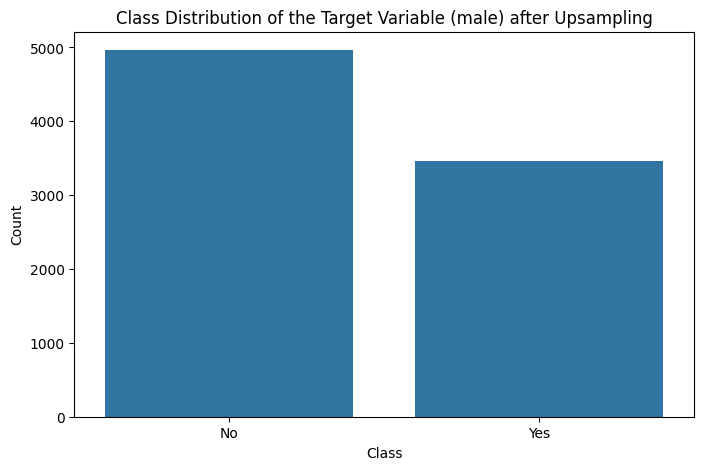

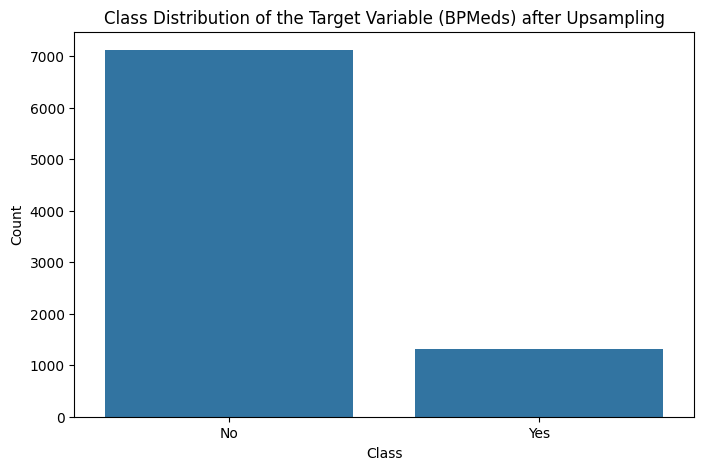

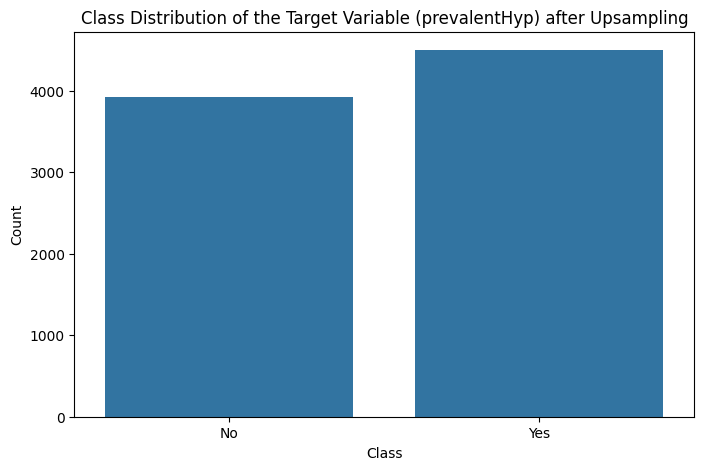

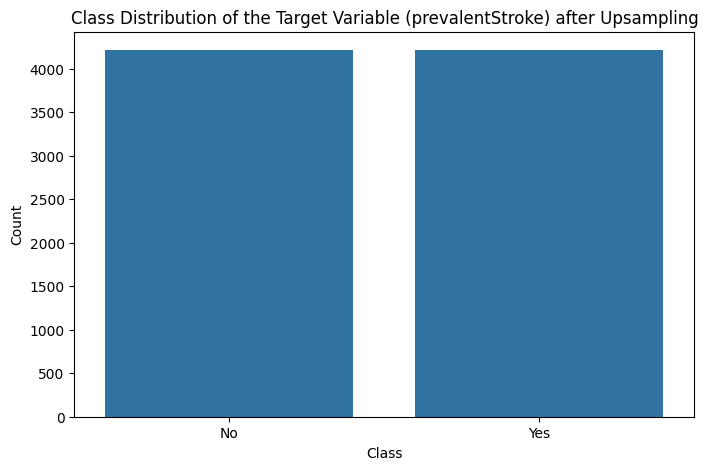

In [55]:
# Plot the class distribution for each target column after upsampling
for target_column in target_columns:
    # Separate majority and minority classes
    data_majority = data_upsampled[data_upsampled[target_column] == 0]
    data_minority = data_upsampled[data_upsampled[target_column] == 1]

    # Plotting the class distribution
    plt.figure(figsize=(8, 5))
    sns.barplot(x=[0, 1], y=[len(data_majority), len(data_minority)])
    plt.title(f'Class Distribution of the Target Variable ({target_column}) after Upsampling')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.show()

Right now I am going to use stepwise selection for upsampledata.
``````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````````

In [56]:
#Define features and target
X = data_upsampled[["age", "cigsPerDay", "totChol", "BMI", "heartRate", 
                "glucose", "TenYearCHD","male", "currentSmoker", "BPMeds", 
                "prevalentHyp", "diabetes", "prevalentStroke"]]
y = data_upsampled["sys_dia_diff"]

#Separate continuous and categorical features
continuous_features = ["age", "cigsPerDay", "totChol", "BMI", "heartRate", "glucose", "TenYearCHD"]
categorical_features = ["male", "currentSmoker", "BPMeds", "prevalentHyp", "diabetes", "prevalentStroke"]

# Standardize continuous features
scaler = StandardScaler()
X_continuous_scaled = scaler.fit_transform(X[continuous_features])

# Convert back to DataFrame
X_continuous_scaled = pd.DataFrame(X_continuous_scaled, columns=continuous_features)

# Combine with categorical features
X_combined = pd.concat([X_continuous_scaled, X[categorical_features].reset_index(drop=True)], axis=1)

In [57]:
selected_interactions = [
    'age' 'cigsPerDay' 'totChol' 'BMI' 'heartRate' 'glucose' 'TenYearCHD'
    'male' 'currentSmoker' 'BPMeds' 'prevalentHyp' 'diabetes''prevalentStroke'
    'age cigsPerDay', 'age BMI', 'age glucose', 'age prevalentHyp',
    'cigsPerDay totChol', 'cigsPerDay BMI', 'cigsPerDay heartRate',
    'totChol BMI', 'totChol diabetes', 'BMI heartRate', 'BMI diabetes', 
    'BMI prevalentHyp', 'heartRate prevalentHyp', 'male age', 'male diabetes'
]
# Generate polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_combined)
poly_feature_names = poly.get_feature_names_out(X_combined.columns)

# Filter the features to keep only selected interactions
selected_indices = [i for i, feature in enumerate(poly_feature_names) if feature in selected_interactions or feature in X_combined.columns]
X_poly_selected = X_poly[:, selected_indices]
poly_feature_names_selected = np.array(poly_feature_names)[selected_indices]

In [58]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_poly_selected, y, test_size=0.2, random_state=27)

# Create a Linear Regression model for faster initial feature selection
model = LinearRegression()

# Initialize Sequential Feature Selector with floating set to True
sfs = SFS(model,
          k_features='best',
          forward=True,
          floating=True,
          scoring=adjusted_r2_scorer,
          cv=5,
          n_jobs=-1)

# Perform stepwise feature selection
sfs.fit(X_train, y_train)

# Check if feature selection was successful
if hasattr(sfs, 'k_feature_idx_') and sfs.k_feature_idx_ is not None:
    # Get the selected features
    selected_feature_indices = list(sfs.k_feature_idx_)
    selected_features = np.array(poly_feature_names_selected)[selected_feature_indices]
    print('Stepwise Selection - Selected Features:', selected_features)

    # Iterate through subsets and print information
    for k in sorted(sfs.subsets_.keys(), reverse=False):
        feature_indices = list(sfs.subsets_[k]['feature_idx'])
        feature_names = [poly_feature_names_selected[i] for i in feature_indices]
        avg_score = sfs.subsets_[k]['avg_score']
        print(f"Number of features: {k}, Features: {feature_names}, Score: {avg_score}")

    # Subset the dataset with the selected features
    X_train_selected = sfs.transform(X_train)
    X_test_selected = sfs.transform(X_test)

    # You can now proceed to fit a model using X_train_selected and evaluate it on X_test_selected
else:
    print("Feature selection failed or no features were selected.")

Stepwise Selection - Selected Features: ['age' 'cigsPerDay' 'totChol' 'heartRate' 'glucose' 'TenYearCHD' 'male'
 'currentSmoker' 'BPMeds' 'prevalentHyp' 'diabetes' 'prevalentStroke'
 'age glucose' 'age prevalentHyp' 'cigsPerDay totChol' 'cigsPerDay BMI'
 'totChol BMI' 'BMI prevalentHyp' 'heartRate prevalentHyp']
Number of features: 1, Features: ['prevalentHyp'], Score: 0.36020501000101185
Number of features: 2, Features: ['age', 'prevalentHyp'], Score: 0.4241153088604145
Number of features: 3, Features: ['age', 'prevalentHyp', 'totChol BMI'], Score: 0.4634956067272117
Number of features: 4, Features: ['age', 'BPMeds', 'prevalentHyp', 'totChol BMI'], Score: 0.500807215732982
Number of features: 5, Features: ['age', 'totChol', 'BPMeds', 'prevalentHyp', 'totChol BMI'], Score: 0.518102083334348
Number of features: 6, Features: ['age', 'totChol', 'BPMeds', 'prevalentHyp', 'age prevalentHyp', 'totChol BMI'], Score: 0.532961238570913
Number of features: 7, Features: ['age', 'totChol', 'glucos

In [59]:
# Fit the RandomForestRegressor model using the selected features on the training data
model.fit(X_train_selected, y_train)

# Predict on the test data using the model
y_pred = model.predict(X_test_selected)

# Evaluate the model 
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1)/(len(y_test)-X_test_selected.shape[1]-1)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)

Mean Squared Error: 104.36138843465396
R-squared: 0.5685969771861613
Adjusted R-squared: 0.5636770147411055


The Adjusted R-squared seems to be working alot better after upsampling the columns that had a large difference between the amount in the majority vs minority class. I will continue to use the upsampled data and this time I will use decision trees and see if the model can get better

In [60]:
# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=27)
rf_model.fit(X_train_selected, y_train)
# Predict on the test set
y_pred = rf_model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1)/(len(y_test)-X_test_selected.shape[1]-1)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)

Mean Squared Error: 70.0763305901542
R-squared: 0.710322550344147
Adjusted R-squared: 0.7070189059603167


In [61]:
from sklearn.feature_selection import SelectFromModel

# Use SelectFromModel for feature selection
sfm = SelectFromModel(rf_model, threshold='median')
sfm.fit(X_train, y_train)

# Get selected features
X_train_selected = sfm.transform(X_train)
X_test_selected = sfm.transform(X_test)

# Train a new model with selected features
new_rf_model = RandomForestRegressor(n_estimators=100, random_state=27)
new_rf_model.fit(X_train_selected, y_train)

RandomForestRegressor(random_state=27)

In [62]:
# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
adjusted_r2 = 1 - (1-r2) * (len(y_test)-1)/(len(y_test)-X_test_selected.shape[1]-1)

print("Mean Squared Error:", mse)
print("R-squared:", r2)
print("Adjusted R-squared:", adjusted_r2)

Mean Squared Error: 70.0763305901542
R-squared: 0.710322550344147
Adjusted R-squared: 0.70807027352266


Now I will try using XGBOOST in hopes the model can get even better.